# <div align='center' id="top"> Testing pipeline  </div>

## `Table of contents`

- ###  <a href="#init">intializeing the models</a> 
- ###  <a href="#test">Testing & visualization</a>


### <div align='center' id="init">Intialization</div>



<div align = "right"><a href="#top" > Back to top </a></div>

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import insightface

In [1]:
def load_models(age_model_path, gender_model_path, face_model_name='buffalo_l'):
    age_model = load_model(age_model_path)
    gender_model = load_model(gender_model_path)
    face_model = insightface.app.FaceAnalysis(name=face_model_name, providers=['CPUExecutionProvider'])
    face_model.prepare(ctx_id=0)
    return age_model, gender_model, face_model

In [2]:
# -----------------------------------------------
# 2. Extract and preprocess faces
# -----------------------------------------------
def extract_and_preprocess_faces(img_path, face_model):
    img = cv2.imread(img_path)
    faces = face_model.get(img)

    if not faces:
        raise ValueError(f"No face detected in image: {img_path}")

    # Take the largest face
    face = sorted(faces, key=lambda f: (f.bbox[2]-f.bbox[0]) * (f.bbox[3]-f.bbox[1]), reverse=True)[0]
    x1, y1, x2, y2 = map(int, face.bbox)
    face_crop = img[y1:y2, x1:x2]
    face_resized = cv2.resize(face_crop, (112, 112))
    face_gray = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)

    # Visualize extracted face
    plt.imshow(face_gray, cmap='gray')
    plt.title("Extracted Face (Grayscale)")
    plt.axis("off")
    plt.show()

    return face, face_gray


In [4]:
# -----------------------------------------------
# 3. Predict Age
# -----------------------------------------------
def predict_age(face_img_gray, age_model):
    img = face_img_gray.astype("float32") / 255.0
    img = np.expand_dims(img, axis=(0, -1))  # (1, 112, 112, 1)
    predicted_age = age_model.predict(img)[0][0]
    print(f"📊 Predicted Age: {predicted_age:.2f} years")
    return predicted_age


In [5]:
# -----------------------------------------------
# 4. Predict Gender
# -----------------------------------------------
def predict_gender(face_img_gray, gender_model):
    img = face_img_gray.astype("float32") / 255.0
    img = np.expand_dims(img, axis=(0, -1))  # (1, 112, 112, 1)
    pred_prob = gender_model.predict(img)[0][0]
    gender = "Male" if pred_prob < 0.5 else "Female"
    print(f"⚥ Predicted Gender: {gender} (Confidence: {pred_prob:.2f})")
    return gender, pred_prob

In [6]:
# -----------------------------------------------
# 5. Match Faces
# -----------------------------------------------
def match_faces(face1, face2, criteria_thresh=1, cos_thresh=0.4, eucl_thresh=1.0, angle_thresh=50):
    def angular_distance(v1, v2):
        cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        return np.arccos(np.clip(cos_sim, -1.0, 1.0)) * (180 / np.pi)

    emb1 = face1.embedding / np.linalg.norm(face1.embedding)
    emb2 = face2.embedding / np.linalg.norm(face2.embedding)

    cos_sim = np.dot(emb1, emb2)
    eucl_dist = np.linalg.norm(emb1 - emb2)
    angle = angular_distance(emb1, emb2)

    votes = sum([
        cos_sim > cos_thresh,
        eucl_dist < eucl_thresh,
        angle < angle_thresh
    ])
    is_match = votes >= criteria_thresh

    print(f"\n Matching Results:")
    print(f"  Cosine Similarity: {cos_sim:.4f} (> {cos_thresh})")
    print(f"  Euclidean Distance: {eucl_dist:.4f} (< {eucl_thresh})")
    print(f"  Angular Distance: {angle:.2f}° (< {angle_thresh})")
    print(f" Final Match Decision: {'Match' if is_match else 'Mismatch'} based on {votes}/3 criteria")

    return {
        "cos_sim": cos_sim,
        "eucl_dist": eucl_dist,
        "angle": angle,
        "is_match": is_match,
        "votes": votes
    }

In [7]:
# -----------------------------------------------
# 6. Final Visualization
# -----------------------------------------------
def visualize_results(img1_path, img2_path, age1, gender1, age2, gender2, match_result):
    img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1)
    axes[0].set_title(f"Age: {age1:.1f} | Gender: {gender1}", fontsize=10)
    axes[0].axis("off")

    axes[1].imshow(img2)
    axes[1].set_title(f"Age: {age2:.1f} | Gender: {gender2}", fontsize=10)
    axes[1].axis("off")

    title_color = "green" if match_result["is_match"] else "red"
    plt.suptitle(f"{'MATCH ✅' if match_result['is_match'] else 'MISMATCH ❌'}  (Votes: {match_result['votes']}/3)", color=title_color, fontsize=14)
    plt.tight_layout()
    plt.show()

### <div align='center' id="test">Testing</div>



<div align = "right"><a href="#top" > Back to top </a></div>

In [11]:
def run_analysis_pipeline(img1_path, img2_path, age_model_path, 
                          gender_model_path,criteria_thresh=1, cos_thresh=0.4, eucl_thresh=1.0, angle_thresh=50):
    # Step 1: Load models
    age_model, gender_model, face_model = load_models(age_model_path,gender_model_path)

    # Step 2: Extract faces
    face1, face_img1 = extract_and_preprocess_faces(img1_path, face_model)
    face2, face_img2 = extract_and_preprocess_faces(img2_path, face_model)

    # Step 3: Predict ages
    age1 = predict_age(face_img1, age_model)
    age2 = predict_age(face_img2, age_model)

    # Step 4: Predict genders
    gender1, _ = predict_gender(face_img1, gender_model)
    gender2, _ = predict_gender(face_img2, gender_model)

    # Step 5: Match faces
    match_result = match_faces(face1, face2,criteria_thresh=1, cos_thresh=0.4, eucl_thresh=1.0, angle_thresh=50)

    # Step 6: Visualize results
    visualize_results(img1_path, img2_path, age1, gender1, age2, gender2, match_result)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Mahmoud/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Mahmoud/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Mahmoud/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Mahmoud/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Mahmoud/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112,

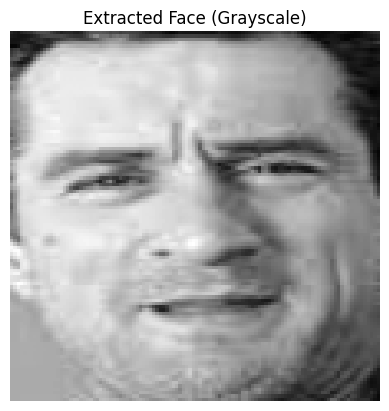

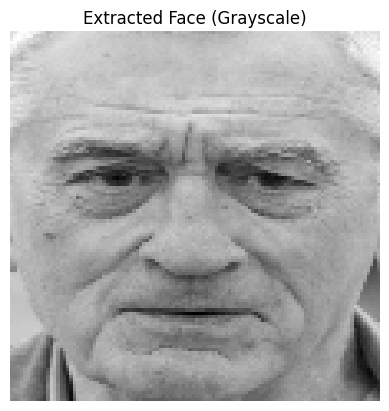

1/1 [==============================] - 0s 148ms/step
📊 Predicted Age: 39.01 years
1/1 [==============================] - 0s 50ms/step
📊 Predicted Age: 59.30 years
1/1 [==============================] - 0s 178ms/step
⚥ Predicted Gender: Male (Confidence: 0.01)
1/1 [==============================] - 0s 18ms/step
⚥ Predicted Gender: Male (Confidence: 0.01)

 Matching Results:
  Cosine Similarity: 0.5354 (> 0.4)
  Euclidean Distance: 0.9640 (< 1.0)
  Angular Distance: 57.63° (< 50)
 Final Match Decision: Match based on 2/3 criteria


C:\Users\Mahmoud\AppData\Local\Temp\ipykernel_31716\2066364846.py:19: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


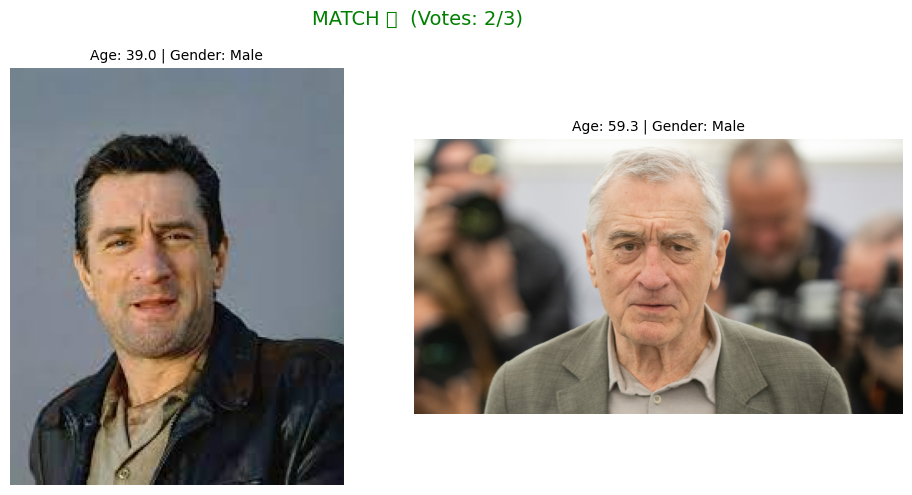

In [ ]:
run_analysis_pipeline("so_di.jpg", "old_di.jpg", "vgg_age.h5", 
                          "squeeze_gender.h5",criteria_thresh=1, cos_thresh=0.4, eucl_thresh=1.0, angle_thresh=50)